In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import math

from scipy.constants import g

In [2]:
WIDTH = 1600
HEIGHT = 1000

AIRCRAFT_SIZE = 24
COLLISION_RADIUS = 2 * AIRCRAFT_SIZE
GOAL_RADIUS = 5 * AIRCRAFT_SIZE
SAFE_DISTANCE = 4 * COLLISION_RADIUS

PLAYER_X = COLLISION_RADIUS
PLAYER_Y = HEIGHT / 2

GOAL_X = WIDTH - GOAL_RADIUS
GOAL_Y = HEIGHT / 2

# KINEMATICS CONSTANTS
AIRSPEED = 200
ACC_LAT_LIMIT = 20 * g

In [3]:
simulation_data_file = "../gym_ACAS2D/models/logs/testing_ACAS2D_PPO_1048576_7_100.csv"
simulation = pd.read_csv(simulation_data_file)
simulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Episode        100 non-null    int64  
 1   Outcome        100 non-null    object 
 2   Total Reward   100 non-null    float64
 3   Time Steps     100 non-null    int64  
 4   Path Length    100 non-null    float64
 5   Path           100 non-null    object 
 6   Traffic Paths  100 non-null    object 
 7   psi            100 non-null    object 
 8   d_sep          100 non-null    object 
 9   a_lat          100 non-null    object 
 10  d_goal         100 non-null    object 
 11  delta_heading  100 non-null    object 
 12  v_closing      100 non-null    object 
 13  d_cpa          100 non-null    object 
 14  d_dev          100 non-null    object 
 15  r_d_goal       100 non-null    object 
 16  r_h_goal       100 non-null    object 
 17  r_d_cpa        100 non-null    object 
 18  r_d_dev    

In [4]:
simulation["Path"] = simulation.apply(lambda row: ast.literal_eval(row["Path"]), axis=1)
simulation["Traffic Paths"] = simulation.apply(lambda row: ast.literal_eval(row["Traffic Paths"]), axis=1)
simulation["psi"] = simulation.apply(lambda row: ast.literal_eval(row["psi"]), axis=1)
simulation["d_sep"] = simulation.apply(lambda row: ast.literal_eval(row["d_sep"]), axis=1)
simulation["a_lat"] = simulation.apply(lambda row: ast.literal_eval(row["a_lat"]), axis=1)
simulation["d_goal"] = simulation.apply(lambda row: ast.literal_eval(row["d_goal"]), axis=1)
simulation["delta_heading"] = simulation.apply(lambda row: ast.literal_eval(row["delta_heading"]), axis=1)
simulation["v_closing"] = simulation.apply(lambda row: ast.literal_eval(row["v_closing"]), axis=1)
simulation["d_cpa"] = simulation.apply(lambda row: ast.literal_eval(row["d_cpa"]), axis=1)
simulation["d_dev"] = simulation.apply(lambda row: ast.literal_eval(row["d_dev"]), axis=1)
simulation["r_d_goal"] = simulation.apply(lambda row: ast.literal_eval(row["r_d_goal"]), axis=1)
simulation["r_h_goal"] = simulation.apply(lambda row: ast.literal_eval(row["r_h_goal"]), axis=1)
simulation["r_d_cpa"] = simulation.apply(lambda row: ast.literal_eval(row["r_d_cpa"]), axis=1)
simulation["r_d_dev"] = simulation.apply(lambda row: ast.literal_eval(row["r_d_dev"]), axis=1)
simulation["r_step"] = simulation.apply(lambda row: ast.literal_eval(row["r_step"]), axis=1)

In [5]:
for index, row in simulation.iterrows():
    assert len(row["Path"]) == len(row["Traffic Paths"][0]) == \
           len(row["psi"]) == len(row["a_lat"]) == \
           len(row["d_sep"]) == len(row["d_goal"]) == \
           len(row["delta_heading"]) == len(row["v_closing"]) ==\
           len(row["d_cpa"]) == len(row["d_dev"]) == row["Time Steps"] == \
           len(row["r_d_goal"]) == len(row["r_h_goal"]) == \
           len(row["r_d_cpa"]) == len(row["r_d_dev"]) ==\
           len(row["r_step"]) == \
           row["Time Steps"]

In [6]:
simulation.head(10)

,Episode,Outcome,Total Reward,Time Steps,Path Length,Path,Traffic Paths,psi,d_sep,a_lat,d_goal,delta_heading,v_closing,d_cpa,d_dev,r_d_goal,r_h_goal,r_d_cpa,r_d_dev,r_step
0,1,Goal,1142.622093,864,1726.0,"[(48, 500.0), (49.99933588666059, 500.05153651...","[[(1552, 48), (1552, 48), (1550.2682011548015,...","[2.4572408207095524, 1.4765758207095525, 0.495...","[1570.4521641871172, 1568.5523856925836, 1564....","[0, -196.13299999999998, -196.13299999999998, ...","[1432.0, 1430.0006650420146, 1428.000740686309...","[2.4572408207095524, 1.4786407321713, 0.498673...","[-383.5366558358088, -384.6435181346255, -385....","[-80.78427185117448, -67.35947211135499, -53.9...","[0.0, -0.05153651434770039, -0.068846851451177...","[0.1538661068142019, 0.15437946432958194, 0.15...","[0.9465026611158013, 0.9675439891774436, 0.988...","[0.03134024191536947, 0.01514920299798381, 0.0...","[1.0, 0.9999640101663689, 0.9999519214339945, ...","[0.029663622372910183, 0.01463256445851136, 0...."
1,2,Timeout,170.723301,1201,2400.0,"[(48, 500.0), (49.997975468067395, 499.9100331...","[[(1552, 48), (1552, 48), (1550.5512416758345,...","[358.1242450086868, 357.4217704010537, 356.729...","[1570.4521641871172, 1568.5129134901204, 1564....","[0, -140.49492152661082, -138.5128779413104, -...","[1432.0, 1430.0020273620087, 1428.005297055002...","[1.8757549913132152, 2.5818342925638262, 3.278...","[-371.73857922701563, -372.3462291412209, -372...","[164.21322359081498, 173.7845629769003, 183.19...","[0.0, 0.08996682166707617, 0.20407706904262568...","[0.1538661068142019, 0.15437911409792462, 0.15...","[0.9589636070267364, 0.9438485630397735, 0.929...","[0.5350909324946604, 0.6711813333815598, 0.828...","[1.0, 0.999937172033539, 0.9998574779240065, 0...","[0.5131327307123795, 0.6323979797140376, 0.767..."
2,3,Goal,1123.849829,907,1812.0,"[(48, 500.0), (49.996836776887854, 499.8875594...","[[(1552, 48), (1552, 48), (1550.186920830651, ...","[357.75778005291477, 356.7771150529148, 355.79...","[1570.4521641871172, 1568.5075290482362, 1564....","[0, -196.13299999999998, -196.13299999999998, ...","[1432.0, 1430.003167643692, 1428.008566842878,...","[2.242219947085232, 3.2273900918663116, 4.2139...","[-391.5743382598032, -392.4089008873426, -393....","[-85.52517294258713, -72.10235087229375, -58.7...","[0.0, 0.11244059083855971, 0.25904056856177254...","[0.1538661068142019, 0.15437882094938282, 0.15...","[0.9510962102369062, 0.9301861644038419, 0.909...","[0.039370499918633416, 0.01988807664876798, 0....","[1.0, 0.999921476951396, 0.9998190893838855, 0...","[0.037445133267744665, 0.01846733082073658, 0...."
3,4,Goal,1096.115612,1044,2086.0,"[(48, 500.0), (49.99976530148179, 500.03063884...","[[(1552, 952), (1552, 952), (1550.521736758849...","[1.8584376672663634, 0.8777726672663635, 359.8...","[1570.4521641871172, 1568.528293801169, 1564.8...","[0, -196.13299999999998, -196.13299999999998, ...","[1432.0, 1430.0002350267484, 1428.000238179596...","[1.8584376672663634, 0.8790002731229833, 0.101...","[-373.6387476900785, -372.7176275103341, -371....","[-147.0632072158358, -133.6772444176431, -120....","[0.0, -0.030638847717943334, -0.02704722968553...","[0.1538661068142019, 0.1543795748800609, 0.154...","[0.9593365850107883, 0.9806092771107787, 0.997...","[0.3442002783847647, 0.23497682072745582, 0.15...","[1.0, 0.9999786039277256, 0.9999811120913961, ...","[0.3302039196254028, 0.23003149435169992, 0.15..."
4,5,Goal,1133.736447,884,1766.0,"[(48, 500.0), (49.99818608383937, 499.91483912...","[[(1552, 48), (1552, 48), (1550.223564852914, ...","[358.5402478585722, 357.5595828585722, 356.578...","[1570.4521641871172, 1568.5140964716568, 1564....","[0, -196.13299999999998, -196.13299999999998, ...","[1432.0, 1430.0018164519527, 1428.005392683420...","[1.4597521414278276, 2.443829275992755, 3.4292...","[-389.512329530738, -390.39347724111303, -391....","[-63.63803970374003, -50.207113587578334, -36....","[0.0, 0.0851608733555622, 0.20450822270362318,...","[0.1538661068142019, 0.

In [7]:
simulation.describe()

,Episode,Total Reward,Time Steps,Path Length
count,100.000000,100.000000,100.000000,100.000000
mean,50.500000,964.750978,955.810000,1909.620000
std,29.011492,375.706890,138.215883,276.431765
min,1.000000,59.931650,768.000000,1534.000000
25%,25.750000,1099.769799,846.750000,1691.500000
50%,50.500000,1129.330481,899.500000,1797.000000
75%,75.250000,1147.279295,1029.750000,2057.500000
max,100.000000,1198.708193,1201.000000,2400.000000


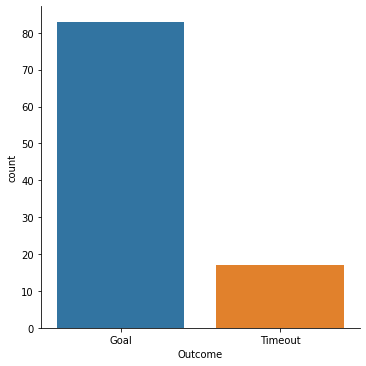

In [8]:
sns.catplot(x="Outcome", data=simulation, kind="count")

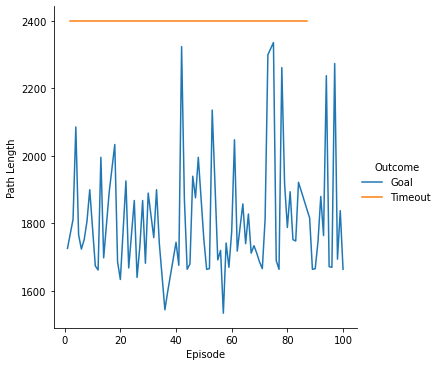

In [9]:
sns.relplot(x="Episode", y="Path Length", data=simulation, 
            kind ="line", 
            hue="Outcome")

<AxesSubplot:xlabel='Outcome', ylabel='Path Length'>

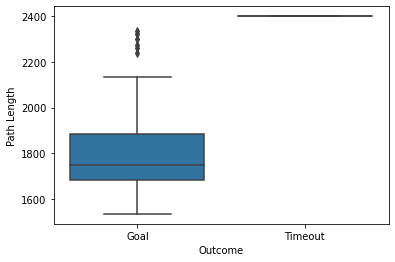

In [10]:
sns.boxplot(x="Outcome", y="Path Length", data=simulation)

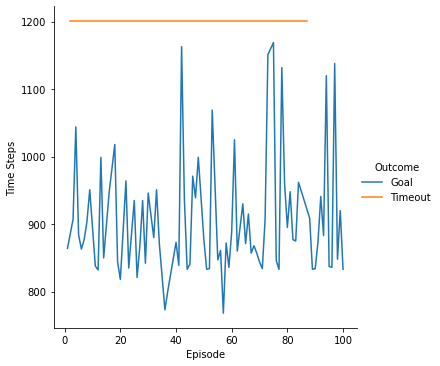

In [11]:
sns.relplot(x="Episode", y="Time Steps", data=simulation, 
            kind ="line", 
            hue="Outcome")

<AxesSubplot:xlabel='Outcome', ylabel='Time Steps'>

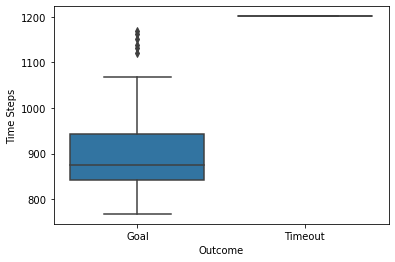

In [12]:
sns.boxplot(x="Outcome", y="Time Steps", data=simulation)

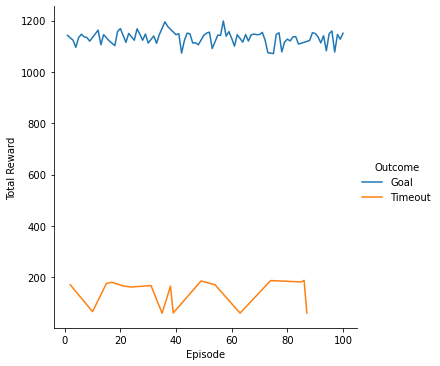

In [13]:
sns.relplot(x="Episode", y="Total Reward", data=simulation, 
            kind ="line", 
            hue="Outcome")

<AxesSubplot:xlabel='Outcome', ylabel='Total Reward'>

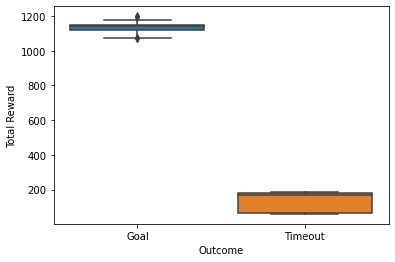

In [14]:
sns.boxplot(x="Outcome", y="Total Reward", data=simulation)

In [15]:
# Create detailed dataframe

"""
#   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Episode        10 non-null     int64  
 1   Outcome        10 non-null     object 
 2   Total Reward   10 non-null     float64
 3   Time Steps     10 non-null     int64  
 4   Path Length    10 non-null     float64
 5   Path           10 non-null     object 
 6   Traffic Paths  10 non-null     object 
 7   psi            10 non-null     object 
 8   d_sep          10 non-null     object 
 9   a_lat          10 non-null     object 
 10  d_goal         10 non-null     object 
 11  delta_heading  10 non-null     object 
 12  v_closing      10 non-null     object 
 13  d_cpa          10 non-null     object 
 14  d_dev          10 non-null     object 
 15  r_d_goal       10 non-null     object 
 16  r_h_goal       10 non-null     object 
 17  r_d_cpa        10 non-null     object 
 18  r_d_dev        10 non-null     object 
 19  r_step         10 non-null     object 
"""

sim = pd.DataFrame()

e_values, o_values, t_values, l_values, tr_values = [], [], [], [], []
x_values, y_values, tx_values, ty_values = [], [], [], []
psi_values, d_sep_values, a_lat_values, d_goal_values,  = [], [], [], []
delta_heading_values, v_closing_values, d_cpa_values, d_dev_values  = [], [], [], []
r_d_goal_values, r_h_goal_values, r_d_cpa_values, r_d_dev_values, r_step_values = [], [], [], [], []

for index, row in simulation.iterrows():
        e_values += [row["Episode"]] * row["Time Steps"]
        o_values += [row["Outcome"]] * row["Time Steps"]
        t_values += list(range(1, row["Time Steps"]+1))
        l_values += [row["Path Length"]] * row["Time Steps"]
        tr_values += [row["Total Reward"]] * row["Time Steps"]
        x_values += [pos[0] for pos in row["Path"]]
        y_values += [-pos[1] for pos in row["Path"]]
        tx_values += [pos[0] for pos in row["Traffic Paths"][0]]
        ty_values += [-pos[1] for pos in row["Traffic Paths"][0]]
        psi_values += row["psi"]
        d_sep_values += row["d_sep"]
        a_lat_values += row["a_lat"]
        d_goal_values += row["d_goal"]
        delta_heading_values += row["delta_heading"]
        v_closing_values += row["v_closing"]
        d_cpa_values += row["d_cpa"]
        d_dev_values += row["d_dev"]
        r_d_goal_values += row["r_d_goal"]
        r_h_goal_values += row["r_h_goal"]
        r_d_cpa_values += row["r_d_cpa"]
        r_d_dev_values += row["r_d_dev"]
        r_step_values += row["r_step"]
        
sim["Episode"] = e_values
sim["Outcome"] = o_values
sim["Time Steps"] = t_values
sim["Path Length"] = l_values
sim["Total Reward"] = tr_values
sim["x"] = x_values
sim["y"] = y_values
sim["tx"] = tx_values
sim["ty"] = ty_values
sim["psi"] = psi_values
sim["d_sep"] = d_sep_values
sim["a_lat"] = a_lat_values
sim["d_goal"] = d_goal_values
sim["delta_heading"] = delta_heading_values
sim["v_closing"] = v_closing_values
sim["v_closing_positive"] = sim.apply(lambda row: row["v_closing"] > 0, axis=1)
sim["d_cpa"] = d_cpa_values
sim["d_dev"] = d_dev_values
sim["r_d_goal"] = r_d_goal_values
sim["r_h_goal"] = r_h_goal_values
sim["r_d_cpa"] = r_d_cpa_values
sim["r_d_dev"] = r_d_dev_values
sim["r_step"] = r_step_values

sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95581 entries, 0 to 95580
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Episode             95581 non-null  int64  
 1   Outcome             95581 non-null  object 
 2   Time Steps          95581 non-null  int64  
 3   Path Length         95581 non-null  float64
 4   Total Reward        95581 non-null  float64
 5   x                   95581 non-null  float64
 6   y                   95581 non-null  float64
 7   tx                  95581 non-null  float64
 8   ty                  95581 non-null  float64
 9   psi                 95581 non-null  float64
 10  d_sep               95581 non-null  float64
 11  a_lat               95581 non-null  float64
 12  d_goal              95581 non-null  float64
 13  delta_heading       95581 non-null  float64
 14  v_closing           95581 non-null  float64
 15  v_closing_positive  95581 non-null  bool   
 16  d_cp

In [16]:
# grid = sns.relplot(x="Episode", y="Closest Approach", data=simulation, 
#                    kind ="line", 
#                    hue="Outcome")

# COL_DISTANCE = 2 * 48
# SAFE_DISTANCE = 4 * 48
# plt.plot([0, 100], [COL_DISTANCE, COL_DISTANCE], linewidth=2, color="red")
# plt.plot([0, 100], [SAFE_DISTANCE, SAFE_DISTANCE], linewidth=2, color="green")

In [17]:
# sns.boxplot(x="Outcome", y="Closest Approach", data=simulation)

In [18]:
# sns.relplot(x="Episode", y="Final Distance to Goal", data=simulation, 
#             kind ="line", 
#             hue="Outcome")

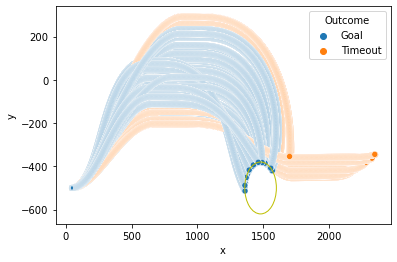

In [19]:
fig, ax = plt.subplots()

sns.scatterplot(x="x", y="y", hue="Outcome", data=sim, ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

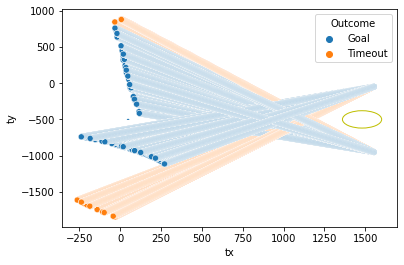

In [20]:
fig, ax = plt.subplots()

sns.scatterplot(x="tx", y="ty", hue="Outcome", data=sim, ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

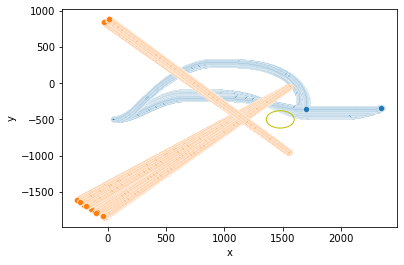

In [21]:
fig, ax = plt.subplots()


sns.scatterplot(x="x", y="y", data=sim[sim["Outcome"]=="Timeout"], ax=ax)
sns.scatterplot(x="tx", y="ty", data=sim[sim["Outcome"]=="Timeout"], ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

<AxesSubplot:xlabel='Time Steps', ylabel='r_step'>

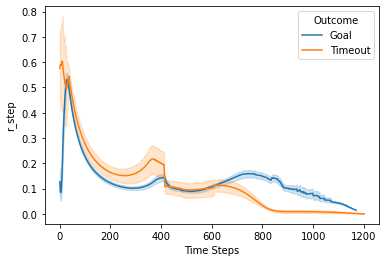

In [22]:
fig, ax = plt.subplots()

# # Ignore high terminal rewards 
# plt.ylim(0, 1)

sns.lineplot(x="Time Steps", y="r_step", hue="Outcome", data=sim, ax=ax)

<AxesSubplot:xlabel='Time Steps', ylabel='delta_heading'>

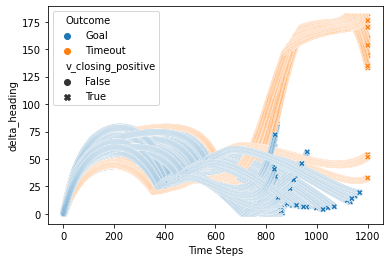

In [23]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="delta_heading", hue="Outcome", style="v_closing_positive" , data=sim, ax=ax)

<AxesSubplot:xlabel='Time Steps', ylabel='d_cpa'>

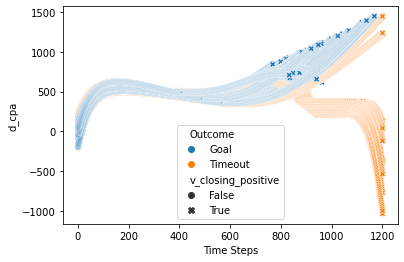

In [24]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="d_cpa", hue="Outcome", style="v_closing_positive" , data=sim, ax=ax)

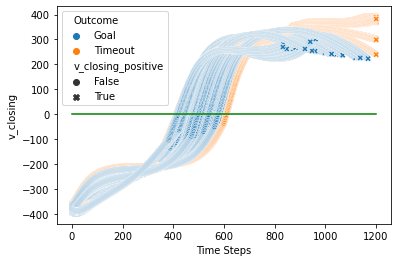

In [25]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="v_closing", hue="Outcome", style="v_closing_positive" , data=sim, ax=ax)

resolution = plt.Line2D([0, 1200], [0, 0], color="g")
ax.add_line(resolution)

<AxesSubplot:xlabel='Time Steps', ylabel='d_sep'>

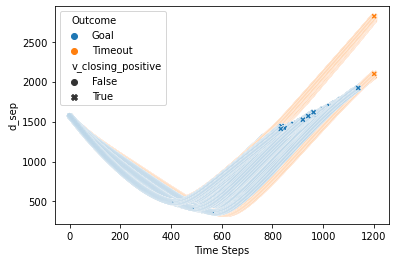

In [26]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="d_sep", hue="Outcome", style="v_closing_positive" , data=sim, ax=ax)

<AxesSubplot:xlabel='Time Steps', ylabel='d_goal'>

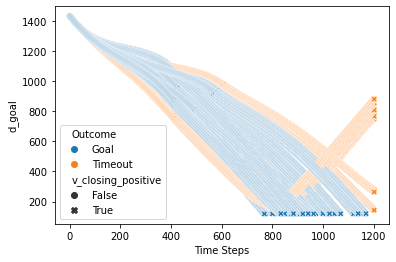

In [27]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="d_goal", hue="Outcome", style="v_closing_positive" , data=sim, ax=ax)

In [ ]:
# a_lats = sim[sim["Episode"]==1]["a_lat"]
 
# actions = [x/ACC_LAT_LIMIT for x in a_lats]

# print(actions)